In [3]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import urllib

import sys
sys.path.append('..')

from ukraine_sentiment.data_processing.utilities import load_geoconfirmed_data
from ukraine_sentiment.graphing import config_matplotlib

config_matplotlib()

In [4]:
oblast_dict = {"Cherkasy": "Cherkas'ka",
               "Chernihiv": "Chernihivs'ka",
               "Chernivtsi": "Chernivets'ka",
               "Crimea": "Crimea",
               "Dnipropetrovs'k": "Dnipropetrovsk",
               "Donets'k": "Donetsk",
               "Ivano-Frankivs'k": "Ivano-Frankivs'ka",
               "Kharkiv": "Kharkiv",
               "Kherson": "Khersons'ka",
               "Khmel'nyts'kyy": "Khmel'nyts'ka",
               "None": "Kirovohrads'ka",
               "Kiev City": "Kyiv city",
               "Kiev": "Kyivs'ka",
               "Luhans'k": "Luhans'ka",
               "L'viv": "Lviv",
               "Mykolayiv": "Mykolaivs'ka",
               "Odessa": "Odessa",
               "Poltava": "Poltavs'ka",
               "Rivne": "Rivnens'ka",
               "Sevastopol'": "Sevastopol' city",
               "Sumy": "Sums'ka",
               "None": "Ternopil's'ka",
               "Vinnytsya": "Vinnyts'ka",
               "Volyn": "Volyns'ka",
               "None": "Zakarpats'ka",
               "Zaporizhzhya": "Zaporiz'ka",
               "Zhytomyr": "Zhytomyrs'ka"
               }
oblast_dict_r = {v:k for k,v in oblast_dict.items()}

In [107]:
event_df, ukraine, front_line = load_geoconfirmed_data()

event_df['date_norm'] = event_df.date.dt.normalize()
oblast_df = event_df.groupby(['date_norm', 'name_1']).size().unstack('name_1')
oblast_df.columns.name = 'Oblast'
oblast_df.index.name = 'Date'

<Axes: xlabel='event_label'>

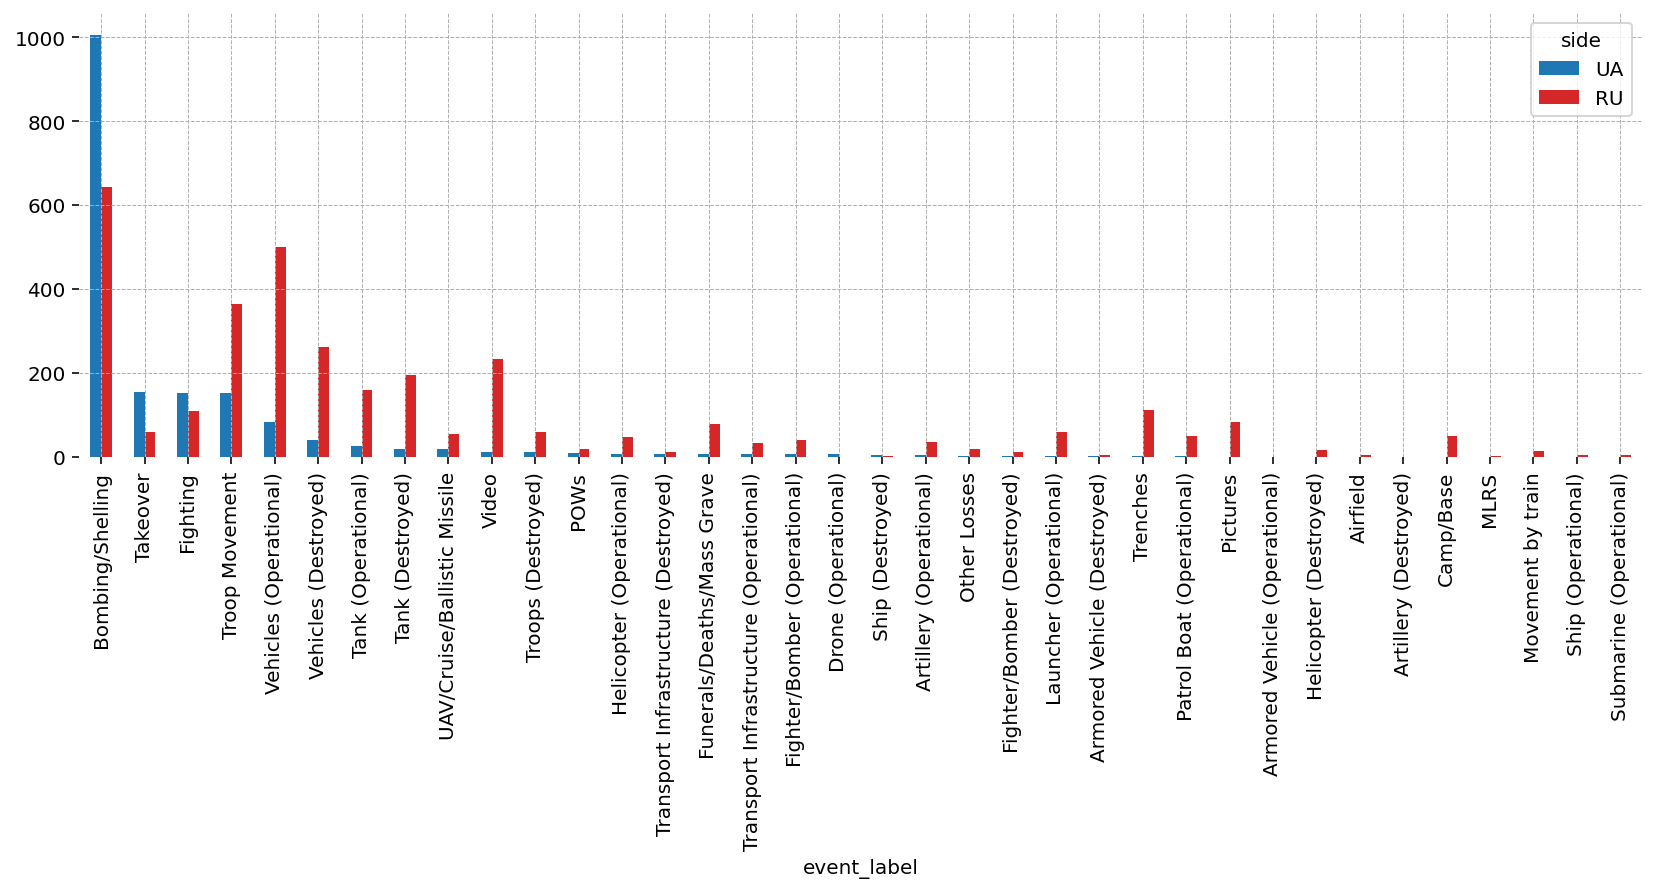

In [138]:
(event_df.groupby(['event_label', 'side'])
     .size()
     .unstack('side')
     .drop(columns=['CBRN', 'CIV', 'NATO', 'NEUTRAL'])
     .dropna(how='all', axis=0)
     .sort_values(by='UA', ascending=False)
     .loc[:, ['UA', 'RU']]
     .plot.bar(color=['tab:blue', 'tab:red']))

<Axes: xlabel='name_1'>

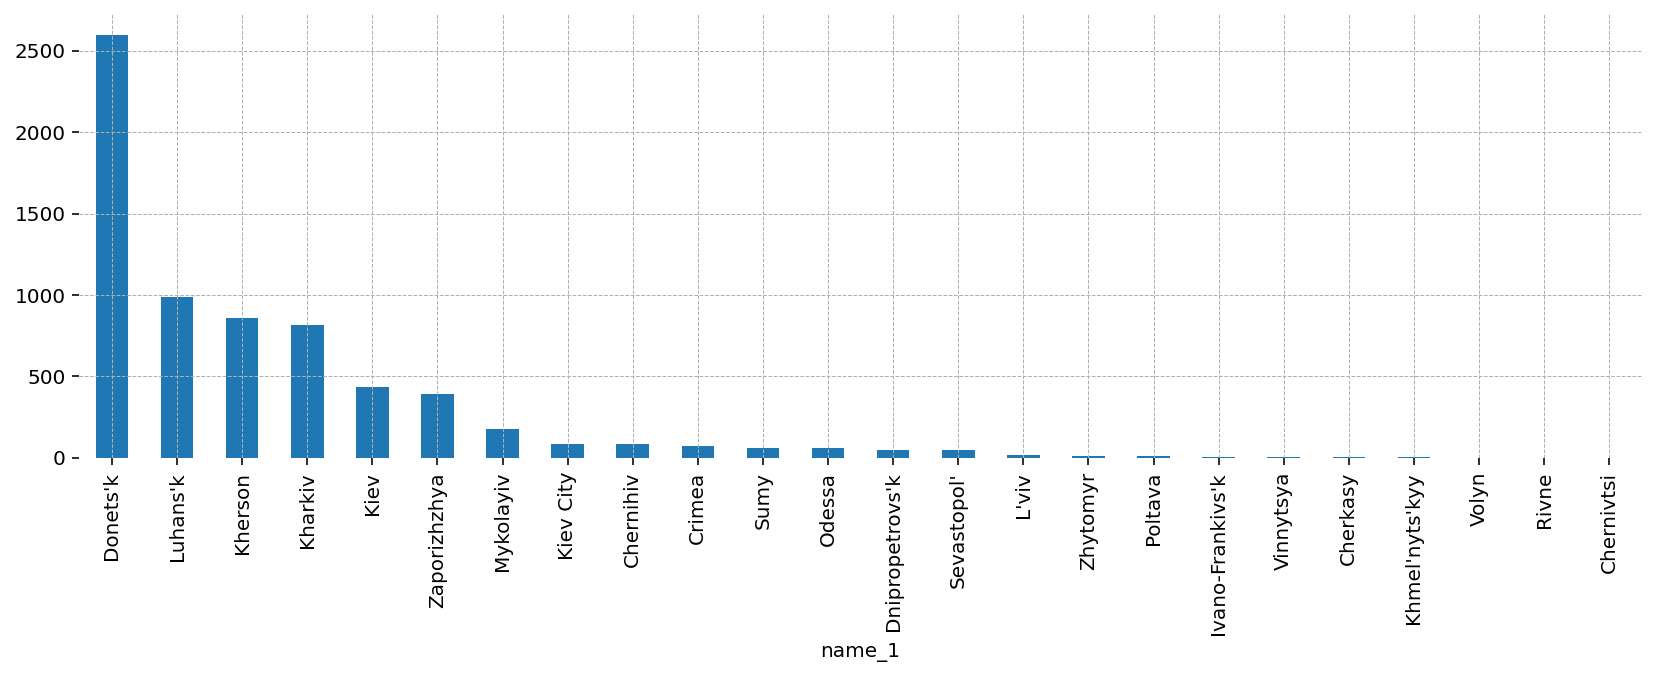

In [115]:
event_df.groupby('name_1').size().sort_values(ascending=False).plot.bar()

In [105]:
gtrends = pd.read_csv('../ukraine_sentiment/data/gtrends/weekly_gtrends_us_dollar.csv',
                      index_col=['date'], parse_dates=True)
weekly_df = gtrends.pivot_table(columns=['oblast'], values='US Dollar', index=gtrends.index)

In [7]:
weekly_attacks = oblast_df.resample(weekly_df.index.inferred_freq).sum().copy()

In [35]:
MinMaxScaler?

In [39]:
def scale_minmax(x, minval, maxval):
    _range = maxval - minval
    x_std = (x - minval) / _range
    x_scaled = x_std
    
    return x_scaled

weekly_attacks_scaled = weekly_attacks.applymap(lambda x: scale_minmax(x, minval=0, maxval=weekly_attacks.max().max()))

In [8]:
weekly_gtrend = weekly_df.loc[weekly_attacks.index].copy()
weekly_gtrend = weekly_gtrend.rename(columns=lambda x: x.replace('oblast', '').replace('Oblast', '').strip())
weekly_gtrend.rename(columns=oblast_dict_r, inplace=True)
weekly_gtrend = weekly_gtrend[[x for x in weekly_attacks if x in weekly_gtrend]]

<Axes: xlabel='Date'>

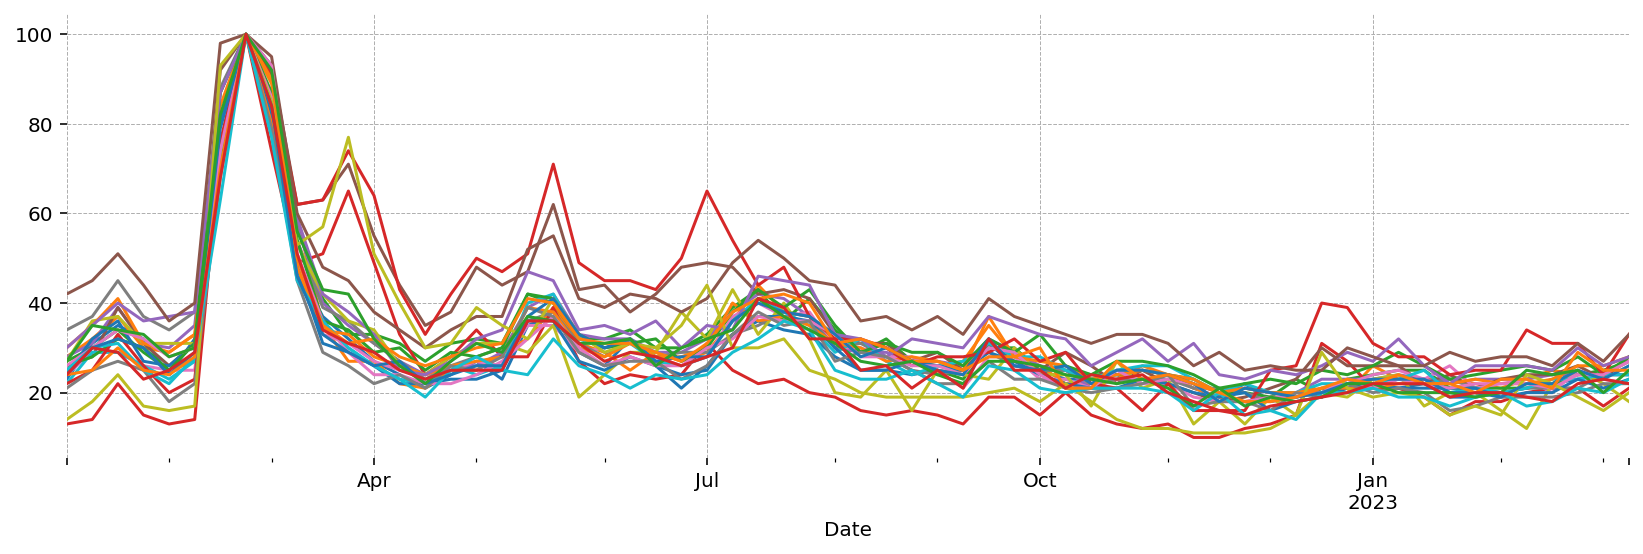

In [106]:
weekly_gtrend.plot(legend=False)

<Axes: xlabel='Date'>

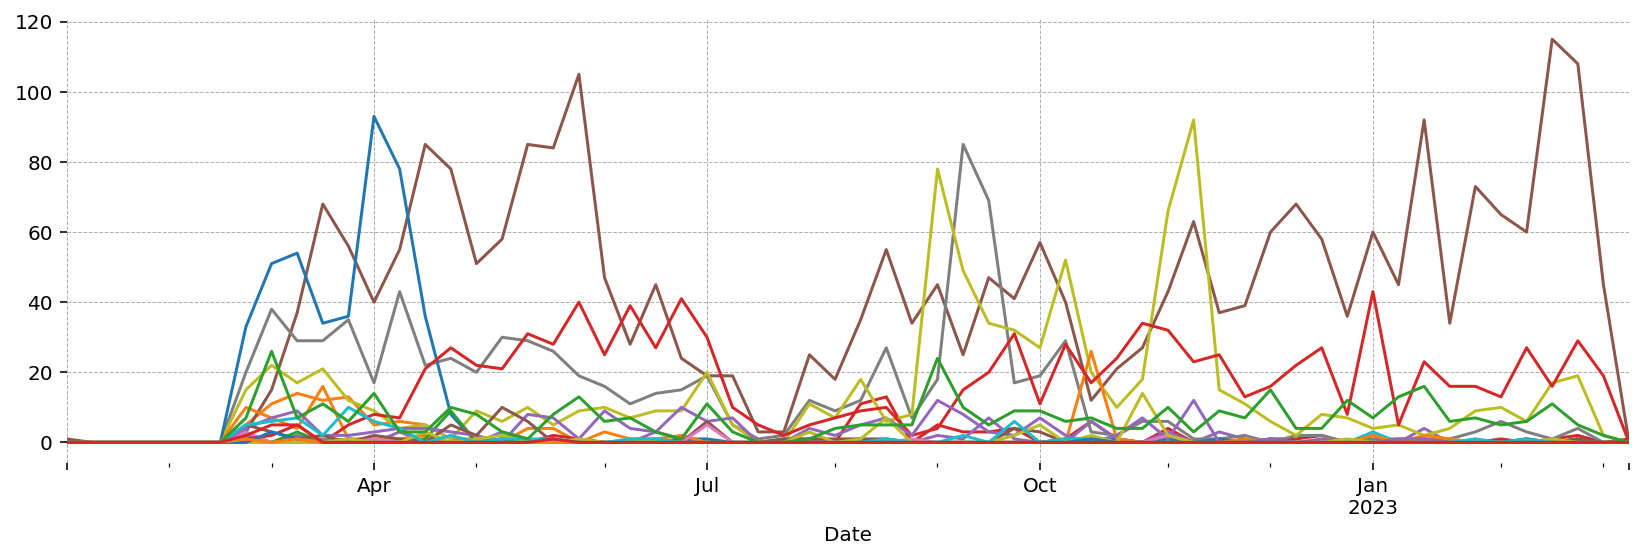

In [104]:
weekly_attacks.plot(legend=False)

In [9]:
from scipy.special import expit, logit
weekly_gtrend_expit = weekly_gtrend.applymap(lambda x: logit(x / 100.1))

In [10]:
from ukraine_sentiment.stat_tools import VAR_tools
from collections import defaultdict
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.pytensorf import collect_default_updates

In [11]:
coords = {
    'oblast':weekly_gtrend.columns,
    'extra_oblast': weekly_gtrend.columns,
    'date': weekly_gtrend.index
}

T, n_regions = weekly_gtrend_expit.shape
k = n_regions ** 2 - n_regions

In [41]:
with pm.Model(coords=coords) as model:    
    gammas = pm.LogitNormal('gamma', dims='oblast')
    
#     r_mu = pm.Normal('r_mu', mu=[0, -3], size=2)
#     r_sigma = pm.HalfNormal('r_sigma', sigma=3, size=2)
#     r_offdiag_offsets = pm.Normal('r_offdiag_offsets', size=k)
#     r_diag_offsets = pm.Normal('r_diag_offsets', dims=['oblast'])
    
#     r_diag = pm.math.invlogit(r_mu[0] + r_sigma[0] * r_diag_offsets)
#     r_offdiag = pm.math.invlogit(r_mu[1] + r_sigma[1] * r_offdiag_offsets)
    
    r_offdiag = pm.LogitNormal('r_offdiag', mu=-3, sigma=1, size=k)
    r_diag = pm.LogitNormal('r_diag', mu=0, sigma=1, dims=['oblast'])
    
    x0 = pm.Normal('x0', size=n_regions)
    
    R = pt.diag(r_diag)
    R = pt.set_subtensor(R[np.triu_indices(n_regions, 1)], r_offdiag[:k // 2])
    R = pt.set_subtensor(R[np.tril_indices(n_regions, -1)], r_offdiag[k // 2:])
    R = pm.Deterministic('R', R, dims = ['oblast', 'extra_oblast'])
    
    Γ = pt.diag(gammas)
    
    sigma_Q = pm.HalfNormal('sigma_Q', sigma=3, dims=['oblast'])
    Q = pt.diag(sigma_Q)
        
    sigma_eta = pm.Gamma('sigma_eta', alpha=2, beta=1, dims=['oblast'])
    Σ = pt.diag(sigma_eta)
        
    def VAR_step(attack, last_x, Γ, R, Q, Σ):
        shock_cov = R @ (attack * Σ + Q) @ R.T
        mu = Γ @ last_x
        x = pm.MvNormal.dist(mu=mu, cov=shock_cov)
        return x, collect_default_updates((attack, last_x, Γ, R, Q, Σ), [x])
        
    var_mean, updates = pytensor.scan(VAR_step, 
                                      sequences=[pt.as_tensor_variable(weekly_attacks_scaled.values)],
                                      outputs_info=[x0],
                                      non_sequences=[Γ, R, Q, Σ],
                                      strict=True)
    
    model.register_rv(var_mean, name = 'VAR_mean', initval='prior')
    intercept = pm.Normal('intercept', dims=['oblast'])
    noise_sigmas = pm.Gamma('noise_sigmas', alpha=2, beta=1, dims=['oblast'])

    obs = pm.Normal('obs', mu = intercept + var_mean, sigma=noise_sigmas, 
                    observed=weekly_gtrend_expit.values, 
                    dims=['date', 'oblast'])
    
    advi2 = pm.ADVI()
    approx2 = advi2.fit(n=1_000_000, obj_optimizer=pm.adam(learning_rate=1e-3), 
                      callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')],
                      fn_kwargs=None)

Interrupted at 76,381 [7%]: Average Loss = 988.61


In [51]:
approx3 = advi2.refine(100_000)

Interrupted at 42,971 [42%]: Average Loss = 64.115


In [52]:
idata = approx2.sample(5000)

In [150]:
# import cloudpickle as pickle

# with open('ukraine_advi_approx.p', 'wb') as file:
#     pickle.dump(approx, file)

In [53]:
with model:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, compile_kwargs={'updates':updates})

Sampling: [obs]


In [54]:
with model:
    priors = pm.sample_prior_predictive(samples=1000, compile_kwargs={'updates':updates})

Sampling: [VAR_mean, gamma, intercept, noise_sigmas, obs, r_diag, r_offdiag, sigma_Q, sigma_eta, x0]


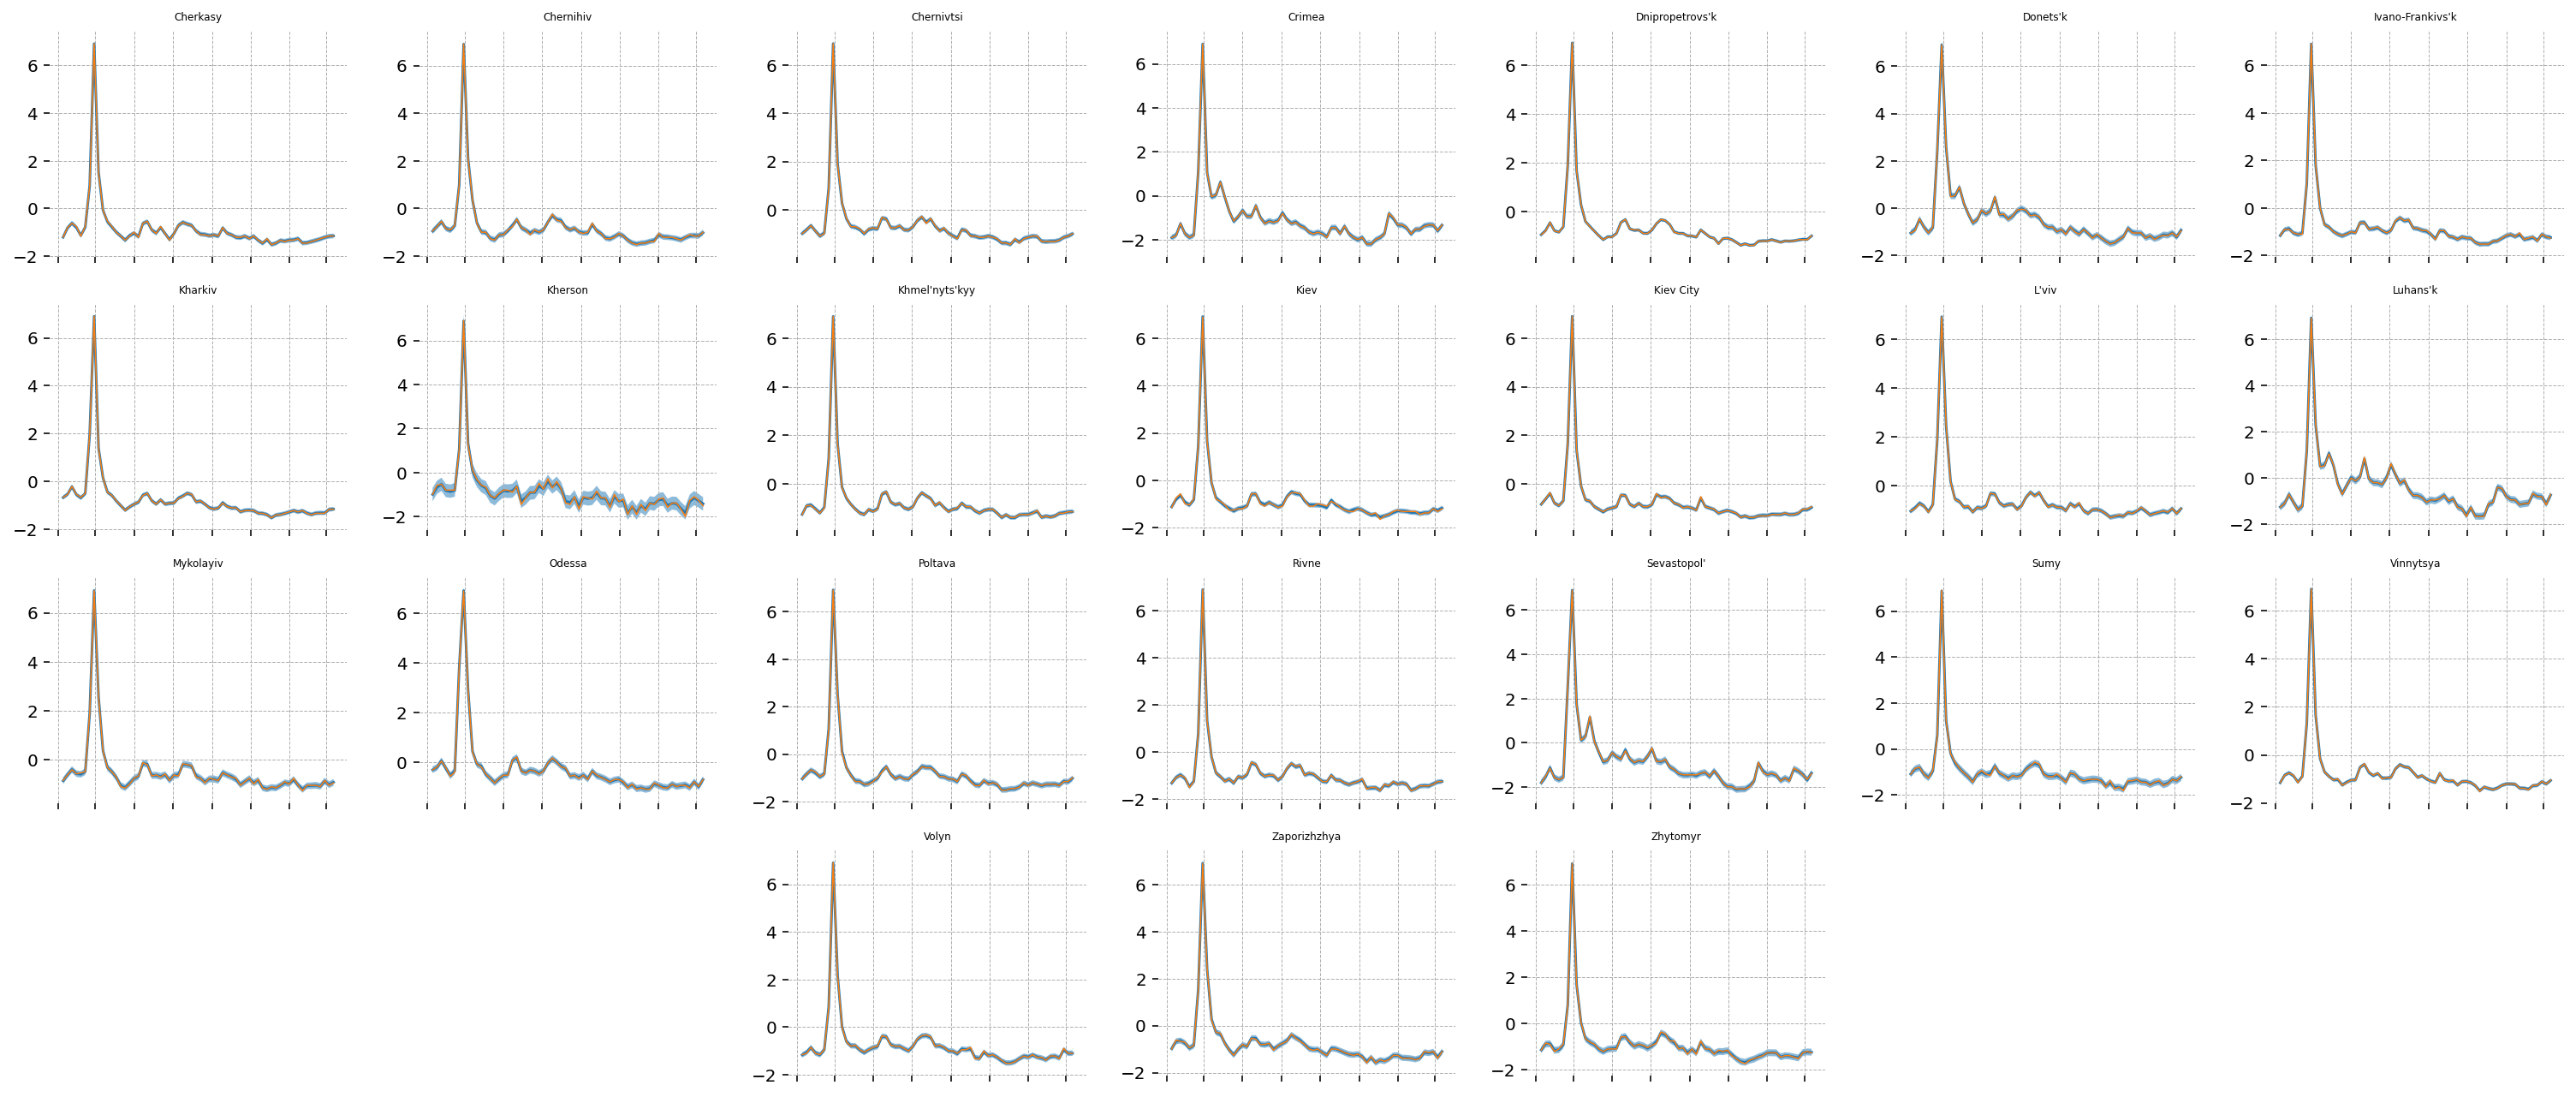

In [62]:
from ukraine_sentiment.graphing.graphing import prepare_gridspec_figure
fig = plt.figure(figsize=(21, 9))
gs, locs = prepare_gridspec_figure(n_cols=7, n_plots=n_regions)

preds = az.extract(idata, 'posterior_predictive').obs
hdi = az.hdi(idata.posterior_predictive.obs).obs

for i, loc in enumerate(locs):
    axis = fig.add_subplot(gs[loc])
    
    axis.plot(weekly_gtrend_expit.index, preds.values.mean(axis=-1)[:, i])
    axis.fill_between(weekly_gtrend_expit.index, *hdi.values[:, i, :].T, alpha=0.5)
    weekly_gtrend_expit.iloc[:, i].plot(ax=axis, lw=0.75)
    axis.set_title(weekly_gtrend_expit.columns[i], fontsize=6)
    axis.set_xlabel('')
    axis.tick_params(axis='x', labelbottom=False)
fig.tight_layout()

[Text(0.5, 172.11999999999995, ''), Text(102.99999999999999, 0.5, '')]

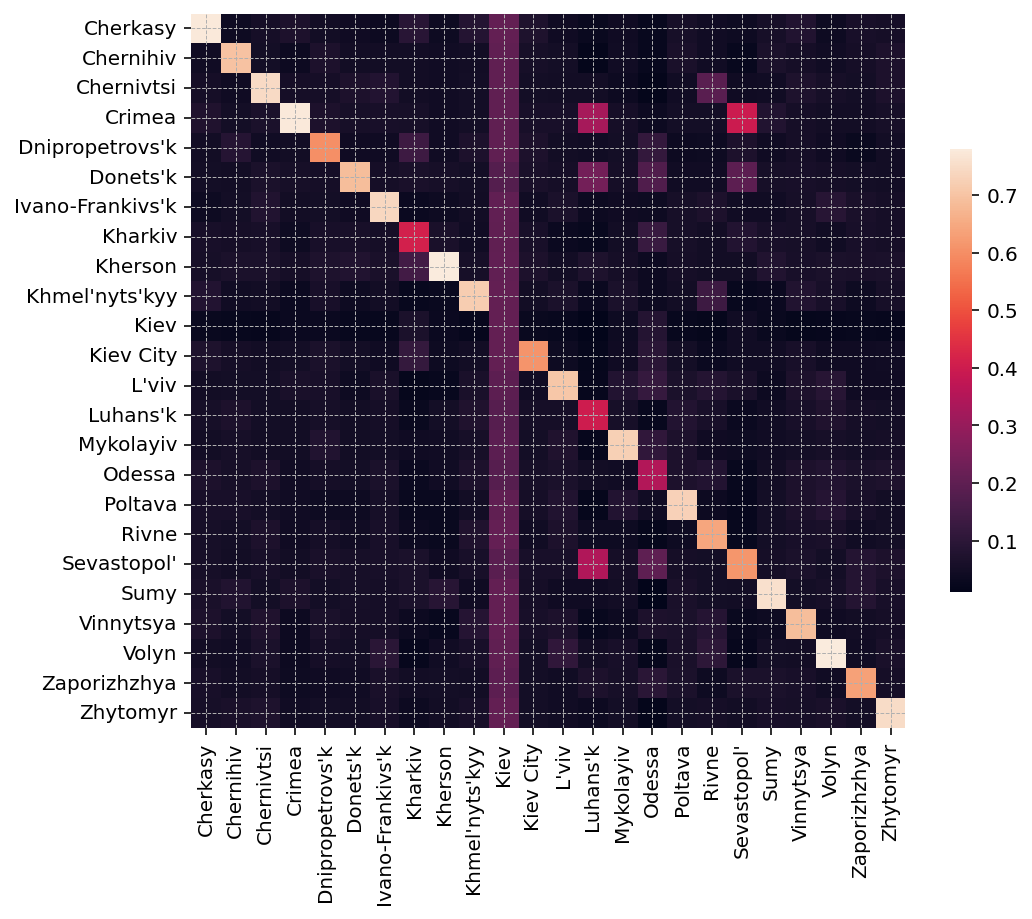

In [63]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8), dpi=144)
sns.heatmap((idata.posterior
                 .R.mean(dim=['chain', 'draw'])
                 .to_dataframe()
                 .unstack('extra_oblast')
                 .droplevel(0, axis=1)
                 .rename(index=lambda x: x.replace('oblast', '').replace('Oblast', ''))
                 .rename(columns = lambda x: x.replace('oblast', '').replace('Oblast', ''))), 
            ax=ax,
            square=True,
            cbar_kws={'shrink':0.5})
ax.set(xlabel='', ylabel='')

In [65]:
Rs = az.extract(idata, 'posterior').R

In [66]:
region_locs = (ukraine[['NAME_1', 'geometry']]
                   .dissolve('NAME_1')
#                    .rename(index=shp_name_to_trend_name)
                   .centroid
                   .apply(lambda x: pd.Series({'x':x.x, 'y':x.y}))
                   .apply(lambda x: (x.x, x.y), axis=1)).to_dict()

In [80]:
from itertools import product
import networkx as nx

def make_graph(A, cols_to_use):
    edges = list(product(cols_to_use, cols_to_use))
    edge_list = [(*ab, {'weight':w}) for ab, w in zip(edges, A.ravel()) if w > 0]
    G = nx.from_edgelist(edge_list, create_using=nx.MultiDiGraph)
    return G

def compute_stats(A, cols_to_use, i):
    G = make_graph(A, cols_to_use)
    pr = nx.pagerank(G)
    auth = nx.hits(G)
    df = (pd.DataFrame(auth, index=['hub', 'authority'])
          .T
          .join(pd.Series(pr, name='page_rank'))
          .melt(ignore_index=False).reset_index())
    df['sample'] = i
    return df


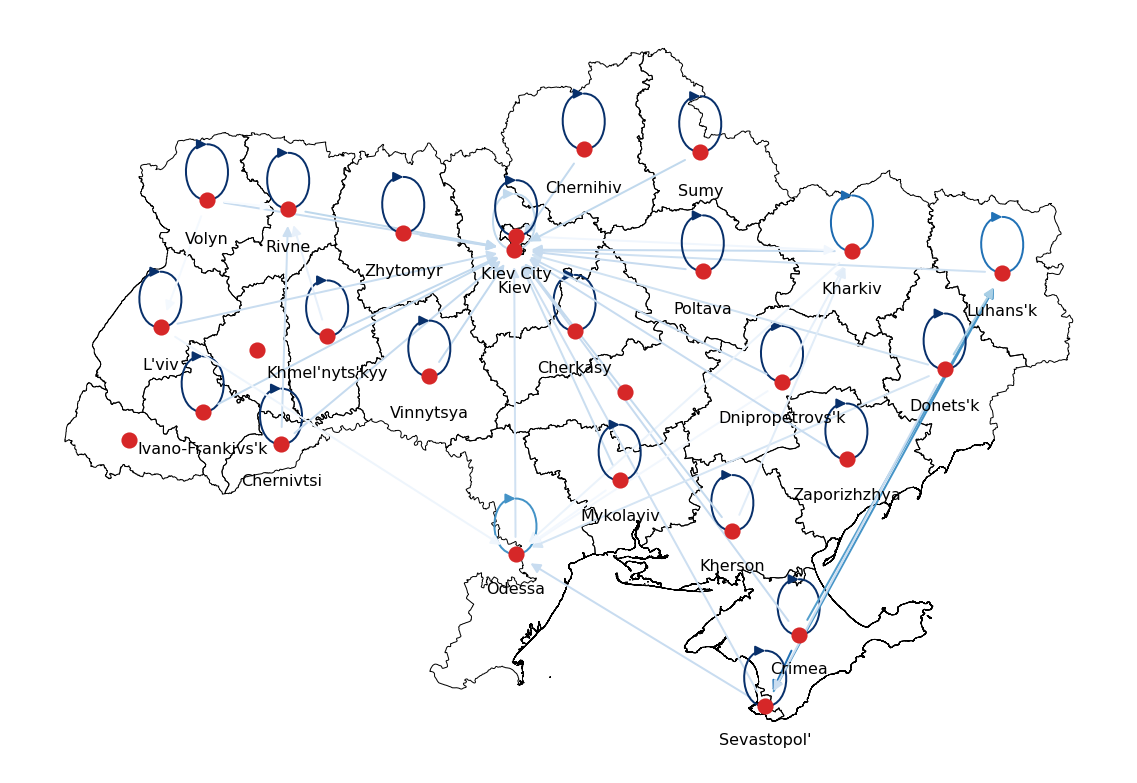

In [68]:
mean_R = Rs.mean(dim=['sample']).values
mean_R[np.where(mean_R < 0.1)] = 0

cols_to_use = weekly_gtrend_expit.columns

G = make_graph(mean_R, cols_to_use)
fig, ax = plt.subplots(figsize=(8,6), dpi=144)
ukraine.dissolve('NAME_1').plot(ax=ax, facecolor='None', edgecolor='k', lw=0.5)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
weights = np.array(weights)

ax.scatter(*np.array(list(region_locs.values())).T, s=50, color='tab:red', zorder=100)

edge_plot = nx.draw_networkx_edges(G, 
                               ax=ax,
                               pos=region_locs,
                               edge_color=weights,
                               edge_cmap=plt.cm.Blues,
                                  edge_vmax=0.5)

for oblast in cols_to_use:
    xy = region_locs[oblast]
    ax.annotate(oblast.replace('oblast', '').replace('Oblast', '').strip(), xy=(xy[0], xy[1] * 0.99), fontsize=8, ha='center')

ax.axis('off')
fig.tight_layout()

In [81]:
res = []
for i, R in enumerate(Rs.values.transpose(2, 0, 1)):
    res.append(compute_stats(R, cols_to_use, i))

In [72]:
stats_df = pd.concat(res, axis=0, ignore_index=True)
stats_df['index'] = stats_df['index'].str.replace('[Oo]blast', '', regex=True)

[Text(0.5, 1.0, 'Posterior PageRank in Fear Transmission Network')]

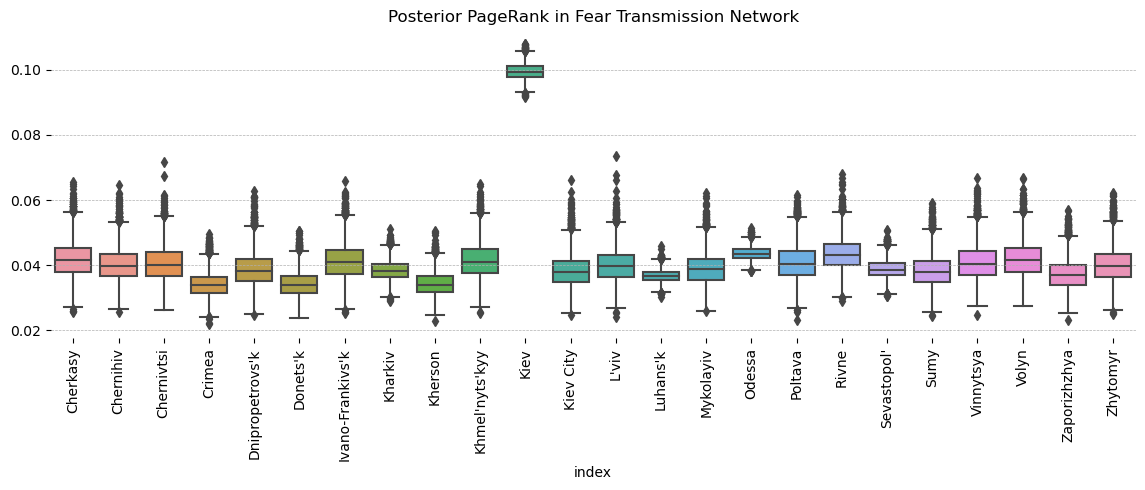

In [73]:
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
sns.boxplot(stats_df[stats_df.variable == 'page_rank'].drop(columns=['variable']).set_index(['index', 'sample']).unstack('index').droplevel(0, axis=1), ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set(title='Posterior PageRank in Fear Transmission Network')

[Text(0.5, 1.0, 'Posterior Hub in Fear Transmission Network')]

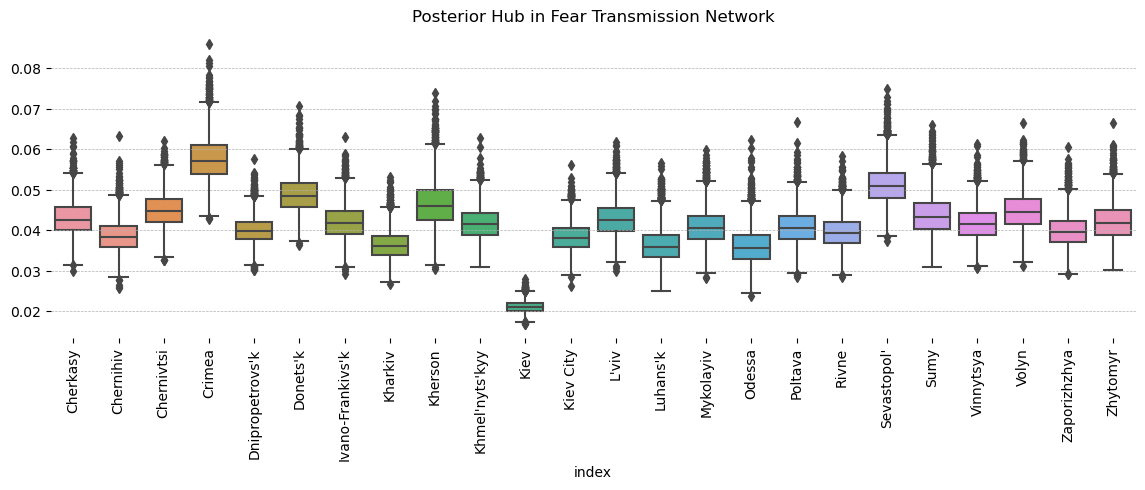

In [74]:
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
sns.boxplot(stats_df[stats_df.variable == 'hub'].drop(columns=['variable']).set_index(['index', 'sample']).unstack('index').droplevel(0, axis=1), ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set(title='Posterior Hub in Fear Transmission Network')

[Text(0.5, 1.0, 'Posterior Authority in Fear Transmission Network')]

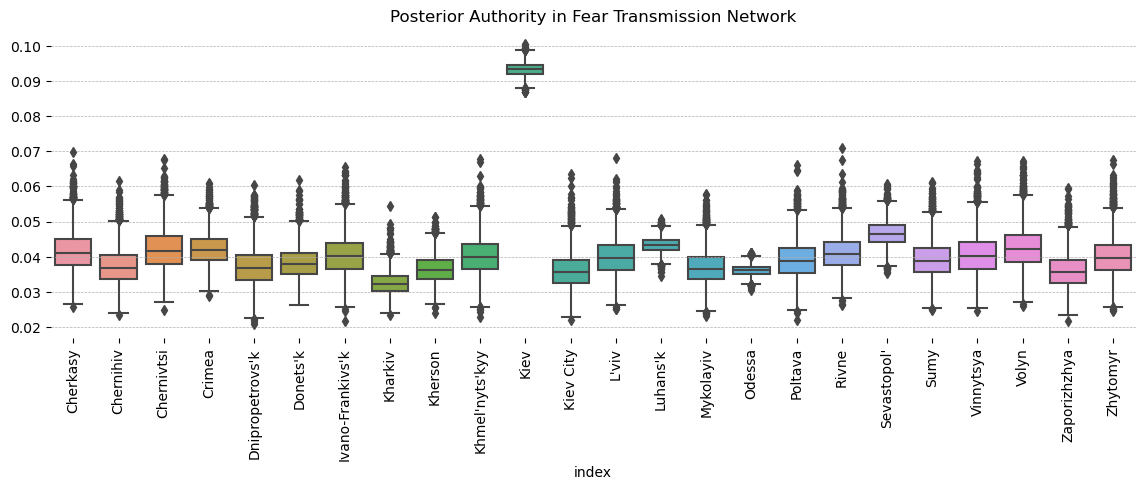

In [75]:
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
sns.boxplot(stats_df[stats_df.variable == 'authority'].drop(columns=['variable']).set_index(['index', 'sample']).unstack('index').droplevel(0, axis=1), ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set(title='Posterior Authority in Fear Transmission Network')

In [89]:
from collections import Counter
clique_counter = Counter()
for i, R in enumerate(Rs.values.transpose(2, 0, 1)):
    G = make_graph(R, cols_to_use)
    cliques = list(map(tuple, nx.clique.find_cliques_recursive(nx.to_undirected(G))))
    clique_counter.update(cliques)

In [101]:
G = make_graph(mean_R, cols_to_use)
cliques = list(map(tuple, nx.find_cycle(G)))
cliques

[('Cherkasy', 'Cherkasy', 0)]

In [90]:
clique_counter.most_common(10)

[(('Kherson',
   'Crimea',
   'Zhytomyr',
   "Luhans'k",
   "Khmel'nyts'kyy",
   'Kiev City',
   'Mykolayiv',
   'Sumy',
   'Kharkiv',
   'Kiev',
   'Chernivtsi',
   'Rivne',
   "Donets'k",
   'Chernihiv',
   'Cherkasy',
   "L'viv",
   'Poltava',
   "Sevastopol'",
   'Odessa',
   "Ivano-Frankivs'k",
   'Volyn',
   "Dnipropetrovs'k",
   'Zaporizhzhya',
   'Vinnytsya'),
  5000)]